<a href="https://colab.research.google.com/github/udlbook/udlbook/blob/main/Notebooks/Chap20/20_3_Lottery_Tickets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook 20.3: Lottery tickets**

This notebook investigates the phenomenon of lottery tickets as discussed in section 20.2.7.  This notebook is highly derivative of the MNIST-1D code hosted by Sam Greydanus at https://github.com/greydanus/mnist1d.   

Work through the cells below, running each cell in turn. In various places you will see the words "TO DO". Follow the instructions at these places and make predictions about what is going to happen or write code to complete the functions.

Contact me at udlbookmail@gmail.com if you find any mistakes or have any suggestions.

In [1]:
# Run this if you're in a Colab to install MNIST 1D repository
!pip install git+https://github.com/greydanus/mnist1d
!git clone https://github.com/greydanus/mnist1d

  Cloning https://github.com/greydanus/mnist1d to /tmp/pip-req-build-uuk1w4f0
  Running command git clone --filter=blob:none --quiet https://github.com/greydanus/mnist1d /tmp/pip-req-build-uuk1w4f0
  Resolved https://github.com/greydanus/mnist1d to commit dc46206f1e1ad7249c96e3042efca0955a6b5d35
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mnist1d: filename=mnist1d-0.0.2.post10-py3-none-any.whl size=14564 sha256=bbac42d433b0447dcccb7b83f6727a28adf31cb2fb639ee03eed0bc3c791eba4
  Stored in directory: /tmp/pip-ephem-wheel-cache-7qc1q6rx/wheels/41/95/55/45fcf7d38cfa97e35682da6c5017d4513729131326ce935371
Successfully built mnist1d
Cloning into 'mnist1d'...
remote: Enumerating objects: 529, done.
remote: Counting objects: 100% (148/148), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 529 (delta 93), reused 104 (delta 66), pack-reused 381 (from 1)
Receiving objec

# Lottery tickets

Lottery tickets were first identified by [Frankle and Carbin (2018)](https://arxiv.org/abs/1803.03635).  They noted that after training a network, they could set the smaller weights to zero and clamp them there and retrain to get a network that was sparser (had fewer parameters) but could actually perform better.  So within the neural network there lie smaller sub-networks which are superior.  If we knew what these were, we could train them from scratch, but there is currently no way of finding out.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import mnist1d
import copy

## Get the MNIST1D dataset

In [3]:
from mnist1d.data import get_dataset, get_dataset_args
from mnist1d.utils import set_seed, to_pickle, from_pickle

import sys ; sys.path.append('./mnist1d/notebooks')
from train import get_model_args, train_model

args = mnist1d.get_dataset_args()
data = mnist1d.get_dataset(args=args)  # by default, this will download a pre-made dataset from the GitHub repo

print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))
print("Length of each input: {}".format(data['x'].shape[-1]))
print("Number of classes: {}".format(len(data['templates']['y'])))

Saving to ./mnist1d_data.pkl
Successfully loaded data from ./mnist1d_data.pkl
Examples in training set: 4000
Examples in test set: 1000
Length of each input: 40
Number of classes: 10


## Make an MLP that can be masked
These parameter-wise binary masks are how we will represent sparsity in this project. There's not a great PyTorch API for this yet, so here's a temporary solution.

In [4]:
# Class to represent linear layer where some of the weights are forced to zero.
class SparseLinear(torch.nn.Module):
  def __init__(self, x_size, y_size):
    super(SparseLinear, self).__init__()
    self.linear = torch.nn.Linear(x_size, y_size)
    param_vec = torch.cat([p.flatten() for p in self.parameters()])
    self.mask = torch.ones_like(param_vec)

  def forward(self, x, apply_mask=True):
    if apply_mask:
      self.apply_mask()
    return self.linear(x)

  def update_mask(self, new_mask):
    self.mask = new_mask
    self.apply_mask()

  def apply_mask(self):
    self.vec2param(self.param2vec())

  def param2vec(self):
    vec = torch.cat([p.flatten() for p in self.parameters()])
    return self.mask * vec

  def vec2param(self, vec):
    pointer = 0
    for param in self.parameters():
      param_len = np.cumprod(param.shape)[-1]
      new_param = vec[pointer:pointer+param_len].reshape(param.shape)
      param.data = new_param.data
      pointer += param_len

# A two layer residual network where the linear layers are sparse
class SparseMLP(torch.nn.Module):
  def __init__(self, input_size, output_size, hidden_size=100):
    super(SparseMLP, self).__init__()
    self.linear1 = SparseLinear(input_size, hidden_size)
    self.linear2 = SparseLinear(hidden_size, hidden_size)
    self.linear3 = SparseLinear(hidden_size, output_size)
    self.layers = [self.linear1, self.linear2, self.linear3]

  def forward(self, x):
    h = torch.relu(self.linear1(x))
    h = h + torch.relu(self.linear2(h))
    h = self.linear3(h)
    return h

  def get_layer_masks(self):
    return [l.mask for l in self.layers]

  def set_layer_masks(self, new_masks):
    for i, l in enumerate(self.layers):
      l.update_mask(new_masks[i])

  def get_layer_vecs(self):
    return [l.param2vec() for l in self.layers]

  def set_layer_vecs(self, vecs):
    for i, l in enumerate(self.layers):
      l.vec2param(vecs[i])

Now we need a routine that takes the weights from the model and returns a mask that identifies the positions with the lowest magnitude.  These will be the weights that we mask.

In [5]:
# absolute weights -- absolute values of all the weights from the model in a long vector
# percent_sparse: how much to sparsify the model
def get_mask(absolute_weights, percent_sparse):
  # TODO -- Write a function that returns a mask that has a zero
  # everywhere for the lowest "percent_sparse" of the absolute weights.
  # E.g. if absolute_weights contains [5,6,0,1,7] and we want percent_sparse of 40%,
  # we would return [1,1,0,0,1]
  # Remember that these are torch tensors and not numpy arrays
  # Replace this function:
  num_weights = len(absolute_weights)
  num_to_mask = int(num_weights * percent_sparse / 100)

  # Sort the absolute weights
  sorted_weights, _ = torch.sort(absolute_weights)

  # Find the threshold value
  threshold = sorted_weights[num_to_mask]

  # Create the mask
  mask = (absolute_weights > threshold).float()



  return mask

## The prune-and-retrain cycle
This is the core method for finding a lottery ticket. We train a model for a fixed number of epochs, prune it, and then re-train and re-prune. We repeat this cycle until we achieve the desired level of sparsity.

In [6]:
def find_lottery_ticket(model, dataset, args, sparsity_schedule, criteria_fn=None, **kwargs):

  criteria_fn = lambda init_params, final_params: final_params.abs()
  init_params = model.get_layer_vecs()
  stats = {'train_losses':[], 'test_losses':[], 'train_accs':[], 'test_accs':[]}
  models = []
  for i, percent_sparse in enumerate(sparsity_schedule):

    # layer-wise pruning, where pruning heuristic is determined by criteria_fn
    final_params = model.get_layer_vecs()
    scores = [criteria_fn(ip, fp) for ip, fp in zip(init_params, final_params)]
    masks = [get_mask(s, percent_sparse) for s in scores]

    # update model with mask and init parameters
    model.set_layer_vecs(init_params)
    model.set_layer_masks(masks)

    # training process
    results = train_model(dataset, model, args)
    model = results['checkpoints'][-1]

    # store stats
    stats['train_losses'].append(results['train_losses'])
    stats['test_losses'].append(results['test_losses'])
    stats['train_accs'].append(results['train_acc'])
    stats['test_accs'].append(results['test_acc'])

    # print progress
    if (i+1) % 1 == 0:
      print('\tretrain #{}, sparsity {:.2f}, final_train_loss {:.3e}, max_acc {:.1f}, last_acc {:.1f}, mean_acc {:.1f}'
            .format(i+1, percent_sparse, results['train_losses'][-1], np.max(results['test_acc']),
            results['test_acc'][-1], np.mean(results['test_acc']) ))
      models.append(copy.deepcopy(model))

  stats = {k: np.stack(v) for k, v in stats.items()}
  return models, stats

## Choose hyperparameters

In [7]:
# train settings
from train import get_model_args, train_model
model_args = get_model_args()
model_args.total_steps = 1501
model_args.hidden_size = 500
model_args.print_every = 5000 # print never
model_args.eval_every = 100
model_args.learning_rate = 2e-2
model_args.device = str('cpu')

Find the lottery ticket by repeatedly training and then pruning weights based on their magnitudes. We'll remove 1% of the weights each time. This is going to take half an hour or so.  Go and have lunch or whatever.

In [8]:
# sparsity settings - we will train 100 models with progressively increasing sparsity
num_retrains = 100
sparsity_schedule = np.linspace(0,1.,num_retrains)

print("Magnitude pruning")
mnist1d.set_seed(model_args.seed)
model = SparseMLP(model_args.input_size, model_args.output_size, hidden_size=model_args.hidden_size)

criteria_fn = lambda init_params, final_params: final_params.abs()
lott_models, lott_stats = find_lottery_ticket(model, data, model_args, sparsity_schedule, criteria_fn=criteria_fn, prune_print_every=1)

Magnitude pruning
	retrain #1, sparsity 0.00, final_train_loss 3.343e-01, max_acc 66.3, last_acc 64.3, mean_acc 58.4
	retrain #2, sparsity 0.01, final_train_loss 2.528e-01, max_acc 63.9, last_acc 63.3, mean_acc 57.5
	retrain #3, sparsity 0.02, final_train_loss 2.505e-01, max_acc 65.6, last_acc 65.6, mean_acc 58.1
	retrain #4, sparsity 0.03, final_train_loss 8.451e-02, max_acc 65.1, last_acc 64.3, mean_acc 57.5
	retrain #5, sparsity 0.04, final_train_loss 1.404e-01, max_acc 65.0, last_acc 63.7, mean_acc 57.9
	retrain #6, sparsity 0.05, final_train_loss 1.852e-01, max_acc 65.6, last_acc 63.3, mean_acc 58.0
	retrain #7, sparsity 0.06, final_train_loss 1.924e-01, max_acc 64.9, last_acc 62.3, mean_acc 57.8
	retrain #8, sparsity 0.07, final_train_loss 1.625e-01, max_acc 64.7, last_acc 64.7, mean_acc 58.0
	retrain #9, sparsity 0.08, final_train_loss 1.367e-01, max_acc 68.3, last_acc 64.7, mean_acc 58.8
	retrain #10, sparsity 0.09, final_train_loss 1.732e-01, max_acc 65.2, last_acc 65.2, mean_

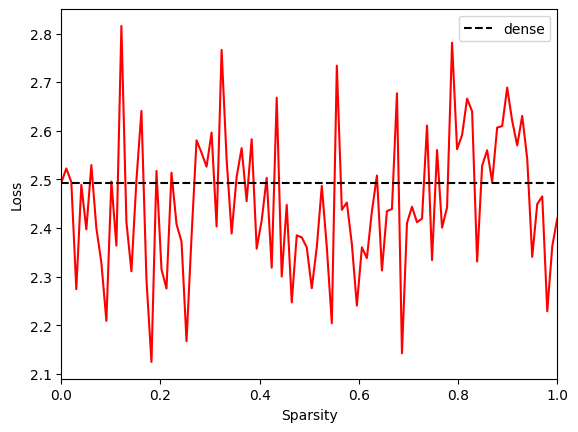

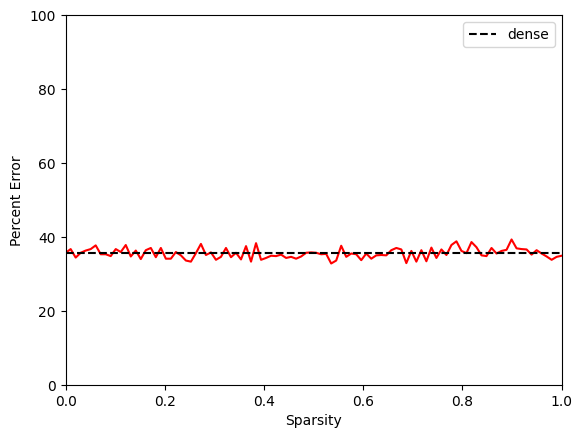

In [9]:
test_losses = lott_stats['test_losses'][:,-1]
test_accs = lott_stats['test_accs'][:,-1]

fig,ax = plt.subplots()
ax.plot(sparsity_schedule, test_losses,'r-')
ax.plot((sparsity_schedule[0], sparsity_schedule[-1]),(test_losses[0], test_losses[0]),'k--',label='dense')
ax.set_xlabel('Sparsity')
ax.set_ylabel('Loss')
ax.set_xlim(0,1)
ax.legend()
plt.show()

fig,ax = plt.subplots()
ax.plot(sparsity_schedule, 100-test_accs,'r-')
ax.plot((sparsity_schedule[0], sparsity_schedule[-1]),(100-test_accs[0], 100-test_accs[0]),'k--',label='dense')
ax.set_xlabel('Sparsity')
ax.set_ylabel('Percent Error')
ax.set_xlim(0,1)
ax.set_ylim(0,100)
ax.legend()
plt.show()


You should see that the test loss decreases and the errors decrease with more as the network gets sparser.  The dashed line represents the original dense (unpruned) network.  We have identified a simpler network that was "inside" the original network for which the results are superior.  Of course if we make it too sparse, then it gets worse again.

This phenomenon is explored much further in the original notebook by Sam Greydanus which can be found [here](https://github.com/greydanus/mnist1d).